In [2]:
# Here I'm trying to load in a file (let's try sea ice concentration),
# starting from the code in hello_world.ipynb
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt

# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [3]:
# Use intake-esm to find a model and experiment
# Access the pangeo cmip6 archive
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col.df.head() # this shows the fields that are available for querying

# query the archive to see what models, experiments, output, etc.
# frequencies are available
import pprint 
uni_dict = col.unique(['experiment_id'])
pprint.pprint(uni_dict, compact=True)

# find a specific experiment, output frequency, variable, and grid
cat = col.search(experiment_id=['historical'], table_id=['SImon'], variable_id=['siconc'])
#cat.df

# using intake-esm, create a 'dictionary' of the files that I can then individually query
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
dset_dict.keys() # list the files

{'experiment_id': {'count': 29,
                   'values': ['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc',
                              '1pctCO2', 'abrupt-4xCO2', 'historical',
                              'piControl', 'amip', 'esm-hist', 'esm-piControl',
                              'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-hindcast-noAgung',
                              'dcppC-hindcast-noElChichon',
                              'dcppC-hindcast-noPinatubo', 'highresSST-present',
                              'control-1950', 'hist-1950', 'deforest-globe',
                              'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
                              'ssp245', 'ssp585']}}
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 21 group(s)


dict_keys(['CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn', 'CMIP.CCCma.CanESM5.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn', 'CMIP.E3SM-Project.E3SM-1-0.historical.SImon.gr', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.SImon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.SImon.gn', 'CMIP.MIROC.MIROC6.historical.SImon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.SImon.gn', 'CMIP.NASA-GISS.GISS-E2-1-H.historical.SImon.gr', 'CMIP.NCAR.CESM2.historical.SImon.gn', 'CMIP.NCAR.CESM2-WACCM.historical.SImon.gn', 'CMIP.NCC.NorCPM1.historical.SImon.gn', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gr', 'CMIP.NUIST.NESM3.historical.SImon.gn', 'CMIP.SNU.SAM0-UNICON.historical.SImon.gn'])

29.5 2014.9575342465753 1856.8732305936073
29.5 2014.9575342465753 1856.8732305936073
29.5 2015.0671232876712 1856.877796803653
29.5 2015.0671232876712 1856.877796803653
708 5807.961643835617 2014.9150684931508
708 5810.591780821918 2015.0246575342467
708 5810.591780821918 2015.0246575342467
29.5 2015.0671232876712 1856.877796803653
708 5810.591780821918 2015.0246575342467
708 5810.591780821918 2015.0246575342467
30 2012.6575342465753 1856.777397260274
30 2012.6575342465753 1856.777397260274
708 5810.591780821918 2015.0246575342467
708 5807.961643835617 2014.9150684931508
708.0 5807.961643835617 2014.9150684931508
29.5 3863.9547945205477 1933.914783105023
708 6167.961643835616 2029.9150684931508
708 5807.961643835617 2014.9150684931508
708 5807.961643835617 2014.9150684931508
15.5 5810.591780821918 2015.0246575342467
708 5807.961643835617 2014.9150684931508


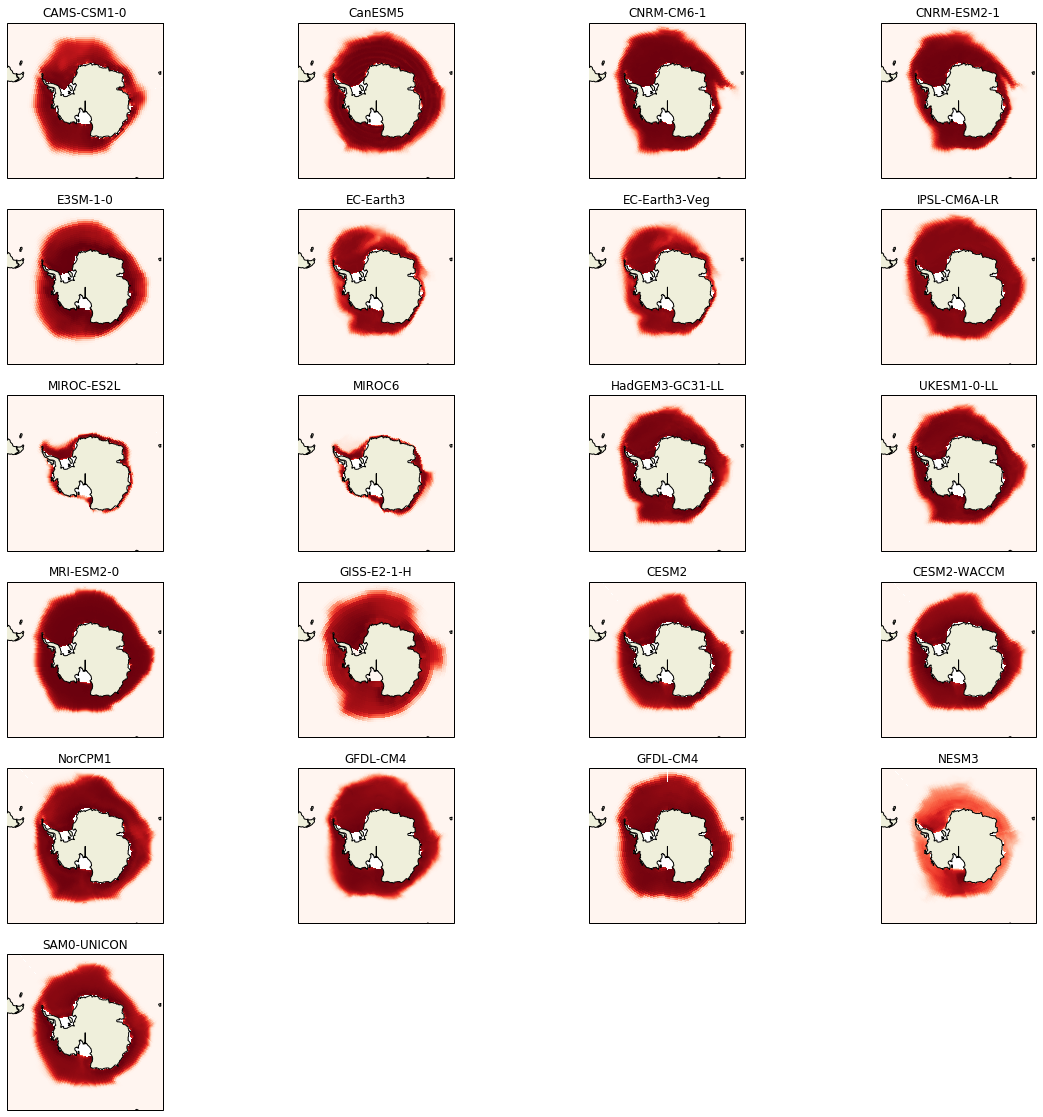

In [52]:
months = 8+12*np.arange(50)
index = 0
fig = plt.figure(figsize=(20,20))
for i in dset_dict:
    #print(index)
    #print(dset_dict[i].variables)
    temp = np.array(dset_dict[i].time)
    print(np.size(temp), temp[1]-temp[0], 1850+temp[-1]/365, 1850+temp[-1]/(24*365))
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in data
    data = dset_dict[i].siconc[0,months,:,:].mean(dim='time')
    data = np.squeeze(np.array(data))
    mydata = data
    
    # A data mask for SouthPolarStereo plots
    mydata = ma.masked_where(latitude>0.,mydata)
    
    # Make a plot
    ax = plt.subplot(6,4,index+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Reds, vmin=0, vmax=100)
    #plt.colorbar(this,orientation='horizontal')
    plt.title(np.str(dset_dict[i].source_id))
    
    index = index+1

In [60]:
months = 8+12*np.arange(50)
index = 0
for i in dset_dict:
    #print(index)
    #print(dset_dict[i].variables)
    temp = np.array(dset_dict[i].time)
    print(np.shape(temp), temp[:6], temp[-1], temp[1]-temp[0], 1850+temp[-1]/365, 1850+temp[-1]/(24*365))
    index = index+1

(1980,) [ 15.5  45.   74.5 105.  135.5 166. ] 60209.5 29.5 2014.9575342465753 1856.8732305936073
(1980,) [ 15.5  45.   74.5 105.  135.5 166. ] 60209.5 29.5 2014.9575342465753 1856.8732305936073
(1980,) [ 15.5  45.   74.5 105.  135.5 166. ] 60249.5 29.5 2015.0671232876712 1856.877796803653
(1980,) [ 15.5  45.   74.5 105.  135.5 166. ] 60249.5 29.5 2015.0671232876712 1856.877796803653
(1980,) [   0  708 1416 2148 2880 3612] 1444656 708 5807.961643835617 2014.9150684931508
(1980,) [   0  708 1416 2148 2880 3612] 1445616 708 5810.591780821918 2015.0246575342467
(1980,) [   0  708 1416 2148 2880 3612] 1445616 708 5810.591780821918 2015.0246575342467
(1980,) [ 15.5  45.   74.5 105.  135.5 166. ] 60249.5 29.5 2015.0671232876712 1856.877796803653
(1980,) [   0  708 1416 2148 2880 3612] 1445616 708 5810.591780821918 2015.0246575342467
(1980,) [   0  708 1416 2148 2880 3612] 1445616 708 5810.591780821918 2015.0246575342467
(1980,) [  0  30  60  90 120 150] 59370 30 2012.6575342465753 1856.777397

In [71]:
#temp = np.array(dset_dict['CMIP.NUIST.NESM3.historical.SImon.gn'].time)
#plt.plot(temp/(24*365))
dset_dict['CMIP.NUIST.NESM3.historical.SImon.gn']

<xarray.Dataset>
Dimensions:    (bnds: 2, member_id: 5, ni: 320, nj: 384, time: 3959, vertices: 4)
Coordinates:
  * time       (time) float64 0.0 15.5 45.0 ... 1.444e+06 1.445e+06 1.446e+06
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' ... 'r4i1p1f1' 'r5i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nj, ni, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    type       |S7 ...
    time_bnds  (time, bnds) float64 dask.array<chunksize=(3959, 2), meta=np.ndarray>
    lon_bnds   (nj, ni, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    siconc     (member_id, time, nj, ni) float